In [1]:

import pandas as pd
import requests
import json
pd.set_option("display.max_columns", None)

import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

dict_pos = {'Lateral':'LAT',
            'Atacante':'ATA',
            'Meia':'MEI',
            'Goleiro':'GOL',
            'Zagueiro':'ZAG',
            'Técnico':'TEC'}


database = '/home/anderson/globo/gitlab/Ferramentas_Automatizadas_Gato_Mestre/database/2023/Cartola_2023'
dataCartola = pd.read_csv(database, compression='gzip')
dataCartola['clube'] = dataCartola['clube'].replace('Athletico-PR', 'Athlético-PR')

rodada_max = dataCartola.rodada_id.max()
rodada_max


37

In [2]:
pontuou = (dataCartola['pontos_num'] != 0) | (dataCartola['variacao_num'] != 0)
jogou_ultima_rodada = dataCartola['rodada_id'] == rodada_max
df_atletas_geral = dataCartola[pontuou]
df_atletas_ultima_rodada = dataCartola[pontuou & jogou_ultima_rodada]

In [3]:
ids_atletas_jogaram = df_atletas_ultima_rodada['atleta_id'].unique()
ids_atletas_nao_jogaram = df_atletas_geral[~df_atletas_geral['atleta_id'].isin(ids_atletas_jogaram)]['atleta_id'].unique()

In [4]:
df_atletas_nao_jogaram = pd.DataFrame()
for id_atleta in ids_atletas_nao_jogaram:
    temp = df_atletas_geral[df_atletas_geral['atleta_id']==id_atleta].sort_values('rodada_id', ascending=False).head(1)
    df_atletas_nao_jogaram = pd.concat([df_atletas_nao_jogaram, temp], axis=0)
    

In [5]:
dfAtletas = pd.concat([df_atletas_ultima_rodada, df_atletas_nao_jogaram], axis=0)

In [6]:
dfAtletas.rename(columns={
    'preco_num': 'ultimo_preco',
    'variacao_num': 'ultima_variacao',
    'pontos_num': 'ultima_pontuacao',
    'media_num': 'ultima_media_pontos',
    'rodada_id': 'ultima_rodada_id'
}, inplace=True)
dfAtletas['pos_sigla'] = dfAtletas['posicao'].map(dict_pos)

In [7]:

def medias_atleta(atleta_id, column):
    atleta = dataCartola[(dataCartola['atleta_id']==atleta_id)]
    ultima_rodada = atleta['rodada_id'].max()
    atleta = atleta[atleta['rodada_id']<ultima_rodada]
    medias = atleta[['preco_open', 'pontos_num', 'variacao_num']].mean()
    return round(medias[column], 2)

def medias_atleta_completa(atleta_id, column, rodada_atual):
    atleta = dataCartola[(dataCartola['atleta_id']==atleta_id)]
    ultima_rodada = atleta['rodada_id'].max()
    atleta = atleta[atleta['rodada_id']<ultima_rodada]
    soma = atleta[['preco_open', 'pontos_num', 'variacao_num']].sum()
    return round((soma[column]/(rodada_atual-1)), 2)


def medias_rodada(rodada_id, column):
    rodada = dataCartola[(dataCartola['rodada_id']==rodada_id)]
    rodada = rodada[(rodada['pontos_num'] != 0) & (rodada['variacao_num'] != 0)]
    medias = rodada[['preco_open', 'pontos_num', 'variacao_num']].mean()
    return round(medias[column], 2)

dfAtletas['preco_medio_at'] = dfAtletas['atleta_id'].apply(lambda x: medias_atleta(x, 'preco_open'))
dfAtletas['pontuacao_media_at'] = dfAtletas['atleta_id'].apply(lambda x: medias_atleta(x, 'pontos_num'))
dfAtletas['variacao_media_at'] = dfAtletas['atleta_id'].apply(lambda x: medias_atleta(x, 'variacao_num'))

dfAtletas['preco_medio_completo_at'] = dfAtletas['atleta_id'].apply(lambda x: medias_atleta_completa(x, 'preco_open', 13))
dfAtletas['pontuacao_media_completa_at'] = dfAtletas['atleta_id'].apply(lambda x: medias_atleta_completa(x, 'pontos_num', 13))
dfAtletas['variacao_media_completa_at'] = dfAtletas['atleta_id'].apply(lambda x: medias_atleta_completa(x, 'variacao_num', 13))

dfAtletas['preco_medio_rodada'] = dfAtletas['ultima_rodada_id'].apply(lambda x: medias_rodada(x, 'preco_open'))
dfAtletas['pontuacao_media_rodada'] = dfAtletas['ultima_rodada_id'].apply(lambda x: medias_rodada(x, 'pontos_num'))
dfAtletas['variacao_media_rodada'] = dfAtletas['ultima_rodada_id'].apply(lambda x: medias_rodada(x, 'variacao_num'))

dfAtletas['diff_preco_medio'] = dfAtletas['ultimo_preco'] - dfAtletas['preco_medio_at']
dfAtletas['diff_pontuacao_media'] = dfAtletas['ultima_pontuacao'] - dfAtletas['pontuacao_media_at']
dfAtletas['diff_variacao_media'] = dfAtletas['ultima_variacao'] - dfAtletas['variacao_media_at']

dfAtletas['diff_preco_medio_completo'] = dfAtletas['ultimo_preco'] - dfAtletas['preco_medio_completo_at']
dfAtletas['diff_pontuacao_media_completa'] = dfAtletas['ultima_pontuacao'] - dfAtletas['pontuacao_media_completa_at']
dfAtletas['diff_variacao_media_completa'] = dfAtletas['ultima_variacao'] - dfAtletas['variacao_media_completa_at']

dfAtletas['diff_preco_medio_geral'] = dfAtletas['ultimo_preco'] - dfAtletas['preco_medio_rodada']
dfAtletas['diff_pontuacao_media_geral'] = dfAtletas['ultima_pontuacao'] - dfAtletas['pontuacao_media_rodada']
dfAtletas['diff_variacao_media_geral'] = dfAtletas['ultima_variacao'] - dfAtletas['variacao_media_rodada']
dfAtletas.fillna(0, inplace=True)

rodada_max
rodada = rodada_max
rodada

37

In [8]:
def linearRegression(X, y):
    print ('Dataset shape: ',X.shape)
    
    ####### Treinando o regressor:
    reg_model = LinearRegression()
    reg_model.fit(X, y)
    print(reg_model)
    print(X.columns)
    print('coef_',reg_model.coef_)
    print('intercept_',reg_model.intercept_)

    # Extraindo a métrica R2 para treino:
    y_pred_test_model = reg_model.predict(X)
    r2_train = r2_score(y, y_pred_test_model)
    print(f'R2 treino: {r2_train : .6f}')
    
    print('R2:', r2_score(y, y_pred_test_model))
    print('MAE: ', mean_absolute_error(y, y_pred_test_model))
    print('MSE:', mean_squared_error(y, y_pred_test_model))
    print('-------------------------\n\n')

    plt.figure(figsize=(10,10))
    plt.scatter(y, y_pred_test_model, c='crimson')
    p1 = max(max(y_pred_test_model), max(y))
    p2 = min(min(y_pred_test_model), min(y))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()
    
    plt.figure(figsize=(10,10))
    sns.residplot(y, y_pred_test_model)
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show() 
    
    yhatFormula = y_pred_test_model
    
    return yhatFormula

In [9]:
def min_valorizar_final(X, rodada):
      val = 0
      
      #### CASO 1
      if X['ultima_rodada_id'] == rodada:
            val = (  0.77734417   *  X['ultima_pontuacao'])    +\
                  (  -0.1315419   *  X['ultima_media_pontos'])    +\
                  (  0.11405842   *  X['ultimo_preco'])    +\
                  0.2547298622279679
      elif X['ultima_rodada_id'] == rodada-1:
            val = (  0.77161675   *  X['ultima_pontuacao'])    +\
                  (  0.0879354   *  X['ultimo_preco'])    +\
                  0.0739029845490462
      elif X['ultima_rodada_id'] == rodada-2:
            val = (  0.75126924   *  X['ultima_pontuacao'])    +\
                  (  0.1659451   *  X['ultimo_preco'])    +\
                  0.013051550247659138
      elif X['ultima_rodada_id'] == rodada-3:
            val = (  1.20423265  *  X['ultima_pontuacao'])    +\
                  (  0.11630456   *  X['ultimo_preco'])    +\
                  0.09116302452052594
      else:  
            if X['jogos_num'] > 1:    
                  if X['ultima_pontuacao'] != 0:
                        val = (   0.75670858   *  X['ultima_pontuacao'])    +\
                              (   0.15137467  *  X['ultimo_preco'])    +\
                              -0.090982954172524
                  else:
                        val = (  -0.94124968  *  X['ultima_pontuacao'])    +\
                              (  1.66073523   *  X['diff_pontuacao_media_geral'])    +\
                              (  0.05203636   *  X['ultimo_preco'])    +\
                              6.520286115546575

            else:
                  val = ( -0.15417763  *  X['ultima_pontuacao'])    +\
                        ( 1.42  *  X['ultimo_preco'])    +\
                        -0.3027862
      return round(val,2)



In [10]:
dfAtletas = dfAtletas.reset_index()

In [11]:
dfAtletas['min_valorizar'] = np.nan
for index, x in dfAtletas.iterrows():
    val = min_valorizar_final(x, rodada)
    dfAtletas['min_valorizar'].iloc[index] = val

In [12]:
dfAtletasaval = dfAtletas[['atleta_id', 'apelido', 'clube', 'jogos_num', 'ultima_pontuacao',  'ultima_media_pontos', 'min_valorizar']]

In [13]:

def carrega_externo(rodada, make_request=False):
    if make_request:
        HOST = 'https://cartolaanalitico.com/api/scouts'
        USER_AGENT = 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Mobile Safari/537.36'
        PAYLOAD = {
        "pos": "",
        "weight_cartoletas": 0
        }
        headers = {'User-Agent': USER_AGENT}
        response = requests.post(url=HOST, data=PAYLOAD, headers=headers)
        response.json()
        with open(f"saved_2023_r{rodada}.json", 'w') as f:
            json.dump(response.json(), f)
    
    
    
    df = pd.read_json(f"saved_2023_r{rodada}.json")
    df = pd.DataFrame.from_dict(df['players'].to_dict(), orient='index')
    df = df.replace('-','0')
    df[['ca', 'dd', 'ds', 'fc', 'fn', 'fs', 'ga', 'ip', 'minval', 'pi',
        'pontos', 'preco', 'sg', 'valor']] = df[['ca', 'dd', 'ds', 'fc', 'fn', 'fs', 'ga', 'ip', 'minval', 'pi',
        'pontos', 'preco', 'sg', 'valor']].astype(float)
    return df

In [14]:
df_analitico = carrega_externo(rodada+1, make_request=True)
df_analitico.head()

,ca,dd,ds,fc,fn,fs,ga,ip,minval,nome,pi,pontos,pos,preco,sg,status,time,valor
0,21.0,0.0,0.6,1.5,2.5,3.3,61.0,0.6,13.3,Hulk,0.0,9.9,ATA,20.63,0.0,Provável,Atlético-MG,-0.6
1,14.0,0.0,0.5,1.4,2.2,2.2,61.0,0.6,2.9,Vegetti,0.0,9.5,ATA,14.53,0.0,Provável,Vasco,1.2
2,13.0,0.0,0.2,1.2,2.1,1.9,59.0,0.8,-0.1,Marcos Leonardo,0.0,8.7,ATA,11.74,0.0,Provável,Santos,1.5
3,18.0,0.0,0.4,1.0,2.1,2.2,56.0,0.6,13.1,Luis Suárez,0.0,8.3,ATA,18.63,0.0,Provável,Grêmio,-0.8
4,17.0,0.0,1.4,1.3,1.1,2.3,47.0,0.2,14.8,Arias,0.0,7.0,MEI,13.04,0.0,Provável,Fluminense,-1.3


In [15]:
dfCompleto = df_analitico.merge(dfAtletas, how='left', left_on=['nome', 'pos', 'time'], right_on=['apelido', 'pos_sigla', 'clube'])
dfCompleto.reset_index(inplace=True)
dfCompleto['diff'] = dfCompleto['min_valorizar'] - dfCompleto['minval'] 
df_aval = dfCompleto.sort_values('diff')


In [16]:
df_aval

,level_0,ca,dd,ds,fc,fn,fs,ga,ip,minval,nome_x,pi,pontos,pos,preco,sg,status,time,valor,index,nome_y,slug,apelido,atleta_id,ultima_rodada_id,clube_id,posicao_id,status_id,ultima_pontuacao,ultimo_preco,ultima_variacao,ultima_media_pontos,jogos_num,clube,posicao,status_pre,FF,FS,G,A,SG,DE,DS,DP,FC,GC,GS,FD,CA,FT,I,PP,CV,PC,PI,PS,preco_open,ano,home_dummy,opponent,team_goals,opp_goals,match_id,adversario_nome,entrou_em_campo,exibir_atleta,minutos_jogados,status_inicial,duracao_1t,duracao_2t,duracao_partida,pontos_por_minuto,pos_sigla,preco_medio_at,pontuacao_media_at,variacao_media_at,preco_medio_completo_at,pontuacao_media_completa_at,variacao_media_completa_at,preco_medio_rodada,pontuacao_media_rodada,variacao_media_rodada,diff_preco_medio,diff_pontuacao_media,diff_variacao_media,diff_preco_medio_completo,diff_pontuacao_media_completa,diff_variacao_media_completa,diff_preco_medio_geral,diff_pontuacao_media_geral,diff_variacao_media_geral,min_valorizar,diff
93,93,15.0,0.0,1.7,0.9,0.5,0.9,21.0,0.1,2.8,Cantillo,0.0,3.8,MEI,6.34,0.0,Provável,Corinthians,0.2,18667.0,Víctor Danilo Cantillo Jiménez,viccantillo,Cantillo,85315.0,25.0,264.0,4.0,7.0,-0.3,6.34,-0.80,4.40,3.0,Corinthians,Meia,Provável,0.0,3.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.14,2023.0,0.0,276.0,1.0,2.0,302933.0,São Paulo,True,True,60.0,titular,48.0,50.0,98.0,-0.005000,MEI,7.53,0.37,0.07,22.59,1.10,0.20,6.51,3.43,0.04,-1.19,-0.67,-0.87,-16.25,-1.40,-1.00,-0.17,-3.73,-0.84,0.64,-2.16
138,138,12.0,0.0,0.4,0.8,0.3,0.8,14.0,0.1,15.0,Madson,0.0,3.4,LAT,8.38,36.0,Provável,Athlético-PR,-1.9,27817.0,Madson Ferreira dos Santos,madson02,Madson,78077.0,37.0,293.0,2.0,7.0,16.9,8.38,2.61,3.56,22.0,Athlético-PR,Lateral,Provável,2.0,19.0,2.0,2.0,7.0,0.0,8.0,0.0,16.0,0.0,0.0,4.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.77,2023.0,1.0,277.0,3.0,0.0,302898.0,Santos,True,True,81.0,titular,50.0,54.0,104.0,0.208642,LAT,6.16,1.71,-0.01,18.48,5.12,-0.02,6.77,3.35,0.05,2.22,15.19,2.62,-10.10,11.78,2.63,1.61,13.55,2.56,13.88,-1.12
184,184,16.0,0.0,1.2,0.7,0.3,0.3,10.0,0.0,13.7,Léo Ortiz,0.0,2.9,ZAG,9.80,18.0,Provável,Bragantino,-1.8,28148.0,Leonardo Rech Ortiz,leo-ortiz,Léo Ortiz,97867.0,37.0,280.0,3.0,7.0,15.4,9.80,2.53,4.60,18.0,Bragantino,Zagueiro,Provável,2.0,6.0,1.0,0.0,9.0,0.0,23.0,0.0,11.0,1.0,0.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,7.27,2023.0,1.0,294.0,1.0,0.0,302895.0,Coritiba,True,True,96.0,titular,47.0,49.0,96.0,0.160417,ZAG,8.30,1.87,-0.05,24.91,5.61,-0.14,6.77,3.35,0.05,1.50,13.53,2.58,-15.11,9.79,2.67,3.03,12.05,2.48,12.74,-0.96
87,87,15.0,0.0,0.5,0.7,1.4,1.1,27.0,0.1,13.5,Vitor Bueno,0.0,3.9,MEI,10.06,0.0,Provável,Athlético-PR,-1.6,27821.0,Vitor Frezarin Bueno,vitor-bueno,Vitor Bueno,87552.0,37.0,293.0,4.0,7.0,15.2,10.06,2.34,4.46,30.0,Athlético-PR,Meia,Provável,27.0,33.0,5.0,5.0,0.0,0.0,14.0,0.0,19.0,0.0,0.0,18.0,7.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,7.72,2023.0,1.0,277.0,3.0,0.0,302898.0,Santos,True,True,81.0,titular,50.0,54.0,104.0,0.187654,MEI,7.46,3.28,0.08,22.37,9.83,0.23,6.77,3.35,0.05,2.60,11.92,2.26,-12.31,5.37,2.11,3.29,11.85,2.29,12.63,-0.87
73,73,15.0,0.0,1.5,1.0,0.3,0.5,9.0,0.0,1.6,João Basso,0.0,4.1,ZAG,3.30,36.0,Provável,Santos,0.4,22582.0,João Othávio Basso,basso-parana,João Basso,93372.0,30.0,277.0,3.0,2.0,0.0,3.30,-0.33,1.56,12.0,Santos,Zagueiro,Dúvida,4.0,6.0,0.0,0.0,0.0,0.0,17.0,0.0,13.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.63,2023.0,0.0,264.0,1.0,1.0,302704.0,Corinthians,True,True,10.0,titular,52.0,59.0,111.0,0.000000,ZAG,3.34,0.98,-0.04,5.29,1.56,-0.06,6.94,3.57,0.06,-0.04,-0.98,-0.29,-1.99,-1.56,-0.27,-3.64,-3.57,-0.39,0.76,-0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,35,14.0,0.0,1.4,0.6,0.7,

# Aqui só se quiser alterar

In [34]:
###CASO 1: 

dfSelecionado = dfCompleto
dfSelecionado = dfSelecionado[dfSelecionado['ultima_rodada_id'] == rodada_max - 3]
variables     = ['ultima_pontuacao',
                 'ultima_media_pontos',
                 'ultimo_preco'
                ]

In [46]:
###CASO 2: 

dfSelecionado = dfCompleto
dfSelecionado = dfSelecionado[dfSelecionado['ultima_rodada_id'] < rodada_max]
dfSelecionado = dfSelecionado[dfSelecionado['jogos_num'] > 1]
dfSelecionado = dfSelecionado[dfSelecionado['ultima_pontuacao'] == 0]

variables     = ['ultima_pontuacao',
                 'diff_pontuacao_media_geral',
                 #'diff_pontuacao_media_completa',
                 'ultimo_preco']

In [42]:
###CASO 3: Mais do que um jogo 

dfSelecionado = dfCompleto
dfSelecionado = dfSelecionado[dfSelecionado['ultima_rodada_id'] == rodada_max]
dfSelecionado = dfSelecionado[dfSelecionado['jogos_num'] > 1]
dfSelecionado = dfSelecionado[dfSelecionado['ultima_pontuacao'] == 0]


In [22]:
###CASO 4: Mais do que um jogo 

dfSelecionado = dfCompleto
dfSelecionado = dfSelecionado[dfSelecionado['ultima_rodada_id'] < rodada_max - 3]
dfSelecionado = dfSelecionado[dfSelecionado['jogos_num'] > 1]
dfSelecionado = dfSelecionado[dfSelecionado['ultima_pontuacao'] == 0]


In [149]:
dfSelecionado = dfCompleto
dfSelecionado = dfSelecionado[dfSelecionado['jogos_num'] == 0]


In [150]:
dfSelecionado.dropna(subset=['slug'], inplace=True)

In [24]:
dfSelecionado.corr()['minval'].sort_values(ascending=False).head(20)

minval                           1.000000
min_valorizar                    0.992559
ultima_pontuacao                 0.988313
diff_pontuacao_media_geral       0.988313
diff_pontuacao_media             0.863765
pontos_por_minuto                0.781217
diff_variacao_media_geral        0.718516
ultima_variacao                  0.718516
diff_pontuacao_media_completa    0.691773
diff_variacao_media              0.635286
diff_preco_medio                 0.629683
diff_variacao_media_completa     0.625989
diff_preco_medio_geral           0.392691
preco                            0.392691
ultimo_preco                     0.392691
ultima_media_pontos              0.391858
home_dummy                       0.379909
team_goals                       0.285119
pontuacao_media_at               0.249829
minutos_jogados                  0.247140
Name: minval, dtype: float64

In [35]:
variables     = ['ultima_pontuacao',
                  'ultimo_preco']

Dataset shape:  (3, 3)
LinearRegression()
Index(['ultima_pontuacao', 'diff_pontuacao_media_geral', 'ultimo_preco'], dtype='object')
coef_ [  0.         -56.94915254  -0.42372881]
intercept_ -201.06101694916745
R2 treino:  1.000000
R2: 1.0
MAE:  2.8440213147481095e-14
MSE: 9.60139247779213e-28
-------------------------




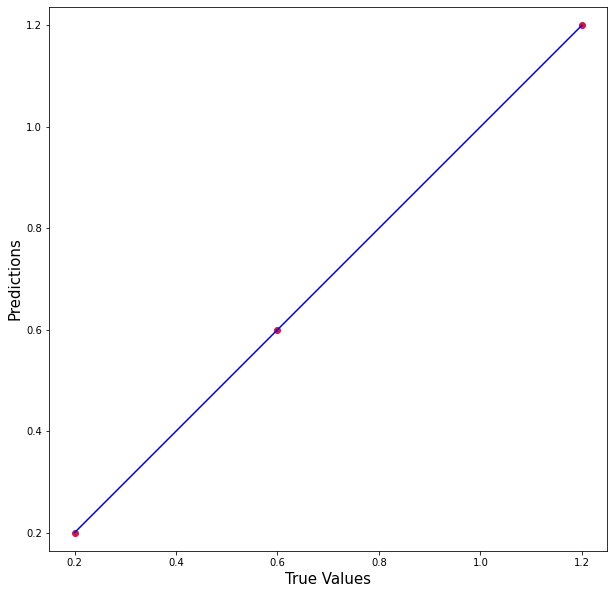

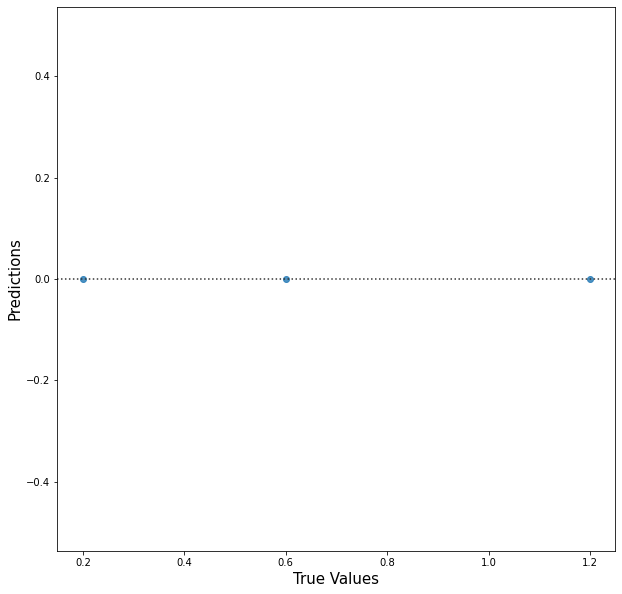

In [47]:
yHat = linearRegression(dfSelecionado[variables], dfSelecionado['minval'])

In [20]:
dfSelecionado = df_teste

In [31]:
dfSelecionado = dfSelecionado[dfSelecionado['jogos_num']>1]

In [32]:
dfSelecionado.corr()['min_valorizar'].sort_values(ascending=False)

min_valorizar                    1.000000
diff_preco_medio_completo        0.838437
ultima_variacao                  0.776870
diff_pontuacao_media_geral       0.762349
diff_variacao_media_completa     0.729239
diff_variacao_media              0.686494
ultimo_preco                     0.670436
ultima_media_pontos              0.653316
diff_variacao_media_geral        0.625445
diff_preco_medio                 0.617390
pontuacao_media_at               0.598603
pontuacao_media_completa_at      0.598545
preco_medio_completo_at          0.476593
preco_medio_at                   0.476149
atleta_id                        0.463550
jogos_num                        0.178147
variacao_media_completa_at      -0.058586
variacao_media_at               -0.061456
diff_preco_medio_geral          -0.094768
ultima_rodada_id                -0.352315
diff_pontuacao_media_completa   -0.598545
diff_pontuacao_media            -0.598603
preco_medio_rodada              -0.759118
variacao_media_rodada           -0

Dataset shape:  (7, 4)
LinearRegression()
Index(['diff_preco_medio_completo', 'ultima_variacao', 'diff_variacao_media',
       'diff_pontuacao_media_geral'],
      dtype='object')
coef_ [ 1.4421092  -1.40595357  1.95448003  0.34281961]
intercept_ 1.3132283131074551
R2 treino:  0.994697
R2: 0.9946973795125429
MAE:  0.19677710659391237
MSE: 0.06584123177507416
-------------------------




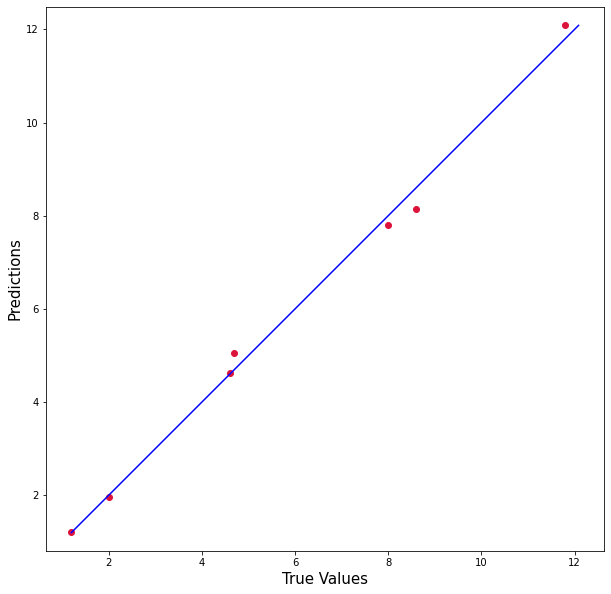

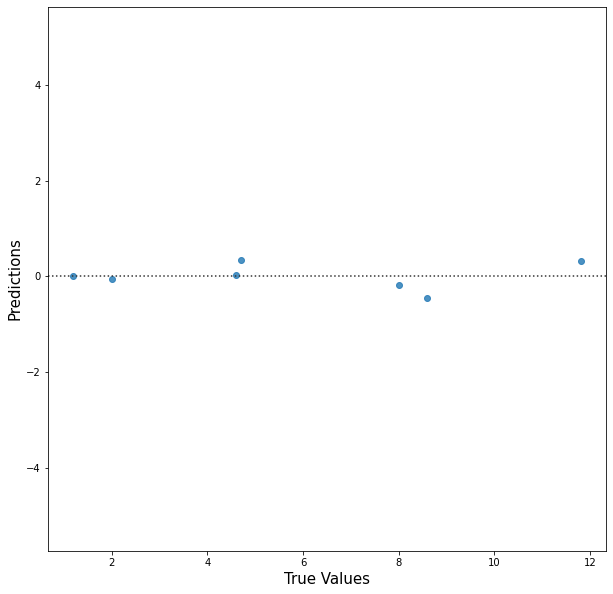

In [36]:
variables = [
            'diff_preco_medio_completo',
            #'diff_preco_medio',
            #'ultima_media_pontos',
            #'ultima_pontuacao',
            #'diff_pontuacao_media',
            'ultima_variacao',
            'diff_variacao_media',
            #'ultimo_preco',
            #'diff_preco_medio',
            #'diff_preco_medio_geral',
            'diff_pontuacao_media_geral',
            #'diff_preco_medio_geral',
            #'ultimo_preco',
            #'diff_pontuacao_media_completa',
            #'diff_pontuacao_media',
            #'diff_preco_medio',
            #'ultima_variacao',
            #'diff_variacao_media',
            #'preco_medio_rodada'    
            #'ultimo_preco',
            #'diff_preco_medio',
            #'diff_variacao_media',
            #'diff_preco_medio',
            #'ultima_media_pontos',
            #'ultimo_preco',
            #'variacao_media_at'
            #'diff_pontuacao_media'
            #'preco_anterior',
            #'media_num_anterior',
            #'pontuacao_anterior',
            #'variacao_anterior',
            #'ultimo_preco',
            #'diff_pontuacao_media',
            #'pontuacao_media_at',
            ##'ultima_media_pontos',
            ##'ultima_pontuacao',
            #'ultima_variacao',
            #'valor', 
            #'variacao_num',
            #'ultimo_preco', 
            ]

yHat = linearRegression(dfSelecionado[variables], dfSelecionado['min_valorizar'])

In [322]:
dfSelecionado['min_valorizar'] = yHat

In [323]:
dfSelecionado['diff'] = dfSelecionado['min_valorizar'] - dfSelecionado['minval']

In [324]:
dfSelecionado.sort_values('diff')

,index,ca,dd,ds,fc,fn,fs,ga,ip,minval,nome,pi,pontos,pos,preco,sg,status,time,valor,atleta_id,apelido,posicao,clube,jogos_num,ultimo_preco,ultima_variacao,ultima_pontuacao,ultima_media_pontos,ultima_rodada_id,pos_sigla,preco_medio_at,pontuacao_media_at,variacao_media_at,preco_medio_completo_at,pontuacao_media_completa_at,variacao_media_completa_at,preco_medio_rodada,pontuacao_media_rodada,variacao_media_rodada,diff_preco_medio,diff_pontuacao_media,diff_variacao_media,diff_preco_medio_completo,diff_pontuacao_media_completa,diff_variacao_media_completa,diff_preco_medio_geral,diff_pontuacao_media_geral,diff_variacao_media_geral,min_valorizar,diff
73,73,15.0,0.0,0.7,1.0,1.1,2.1,29.0,0.2,8.7,Soteldo,0.0,4.5,ATA,9.26,0.0,Provável,Santos,-0.9,87258,Soteldo,Atacante,Santos,2,9.26,-0.03,7.7,5.05,3,ATA,9.73,1.68,-0.46,4.86,0.84,-0.23,6.85,3.63,0.09,-0.47,6.02,0.43,4.40,6.86,0.20,2.41,4.07,-0.12,8.7,-9.592327e-14
16,16,15.0,0.0,1.9,1.0,0.4,0.9,18.0,0.1,6.5,Varela,0.0,5.7,LAT,5.00,42.0,Dúvida,Flamengo,-0.2,84816,Varela,Lateral,Flamengo,0,5.00,0.00,0.0,0.00,1,LAT,5.00,0.00,0.00,2.50,0.00,0.00,6.56,3.79,0.12,0.00,0.00,0.00,2.50,0.00,0.00,-1.56,-3.79,-0.12,6.5,1.421085e-14
203,203,13.0,0.0,0.6,0.5,0.3,0.4,9.0,0.1,3.8,Nathan Silva,0.0,2.9,ZAG,5.25,31.0,Provável,Atlético-MG,-0.2,95794,Nathan Silva,Zagueiro,Atlético-MG,2,5.25,0.45,5.8,5.65,6,ZAG,4.97,0.97,0.04,2.48,0.48,0.02,6.73,4.00,0.06,0.28,4.83,0.41,2.77,5.32,0.43,-1.48,1.80,0.39,3.8,3.996803e-14
61,61,14.0,0.0,1.7,0.9,0.4,0.5,16.0,0.1,4.9,Fernando,0.0,4.7,LAT,4.48,35.0,Provável,Athlético-PR,-0.0,106950,Fernando,Lateral,Athlético-PR,2,4.48,1.26,8.5,6.60,6,LAT,3.04,1.42,0.25,1.52,0.71,0.12,6.73,4.00,0.06,1.44,7.08,1.01,2.96,7.79,1.14,-2.25,4.50,1.20,4.9,9.059420e-14


# Aqui preparando para entregar

In [19]:
df_min_valorizar = dfAtletas.copy()
df_avaliacao = df_min_valorizar[['jogos_num', 'atleta_id', 'apelido', 'clube', 'min_valorizar']]

dict_json = {"assinante": True,
             "rodada": rodada+1,
             "atletas": df_min_valorizar[['atleta_id', 'min_valorizar']].set_index('atleta_id').to_dict()['min_valorizar']
             }

df = pd.DataFrame.from_dict(dict_json, orient='index')
df[0].to_json(path_or_buf=f'2023/minimor{rodada+1}.json')
